In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from uav_active_sensing.config import PROCESSED_DATA_DIR
from uav_active_sensing.pytorch_dataloaders import TinyImageNetDataset
from uav_active_sensing.env import ImageEnv

import random as rd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import resize

2025-02-01 16:56:24.580 | INFO     | uav_active_sensing.config:<module>:11 - PROJ_ROOT path is: /home/tcouso/uav_active_sensing


In [21]:
cifar10_processed_dir = PROCESSED_DATA_DIR / "cifar10"

cifar10_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train_dataset = datasets.CIFAR10(
    root=cifar10_processed_dir, train=True, download=False, transform=cifar10_transform
)
cifar10_test_dataset = datasets.CIFAR10(
    root=cifar10_processed_dir, train=False, download=False, transform=cifar10_transform
)

cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=1, shuffle=False)

In [30]:

TINY_IMAGENET_PROCESSED_DIR = PROCESSED_DATA_DIR / "tiny_imagenet/tiny-imagenet-200"

tiny_imagenet_transform = transforms.Compose([
    # transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tiny_imagenet_train_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="train", transform=tiny_imagenet_transform
)
tiny_imagenet_val_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="val", transform=tiny_imagenet_transform
)

tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, shuffle=True)
tiny_imagenet_val_loader = DataLoader(tiny_imagenet_val_dataset, batch_size=1, shuffle=False)

## Reconstruct image with trained autoencoder

In [38]:
from transformers import AutoImageProcessor, ViTMAEForPreTraining
from uav_active_sensing.plots import visualize_tensor


In [31]:
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

In [32]:
image_processor

ViTImageProcessorFast {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [33]:
model

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTMAELayer(
          (attention): ViTMAESdpaAttention(
            (attention): ViTMAESdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_features=

### Inputs

In [43]:
image, _ = tiny_imagenet_train_dataset[15080]
inputs = image_processor(images=image, return_tensors="pt")

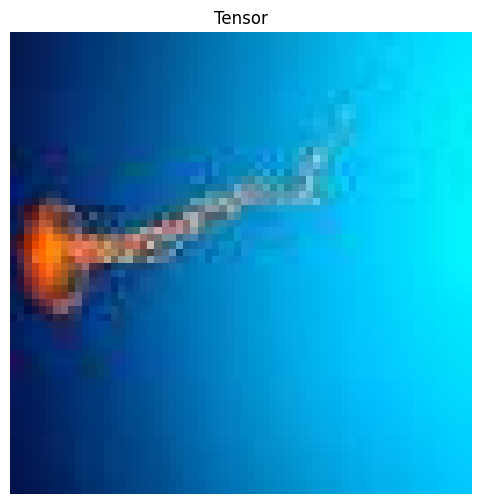

In [45]:
visualize_tensor(transforms.functional.pil_to_tensor(image))

In [54]:
inputs["pixel_values"].squeeze(0).shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


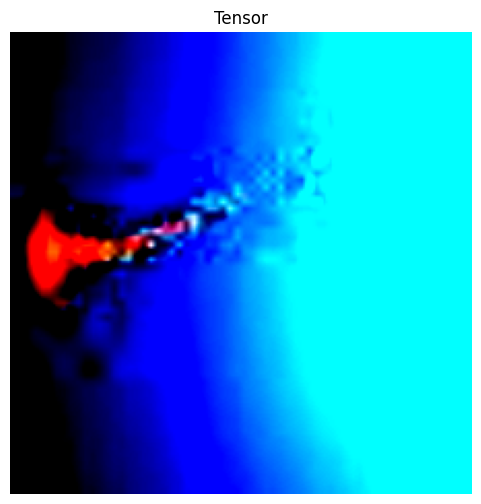

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179044..2.64].


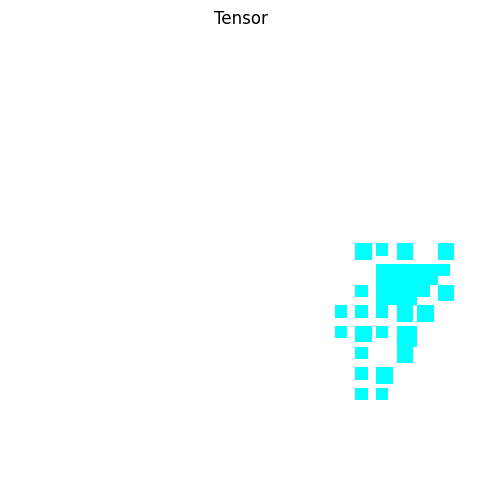

In [66]:
IMG_FOV_RATIO = 32

adapted_inputs = inputs["pixel_values"].squeeze(0)
env = ImageEnv(adapted_inputs, IMG_FOV_RATIO)

env.random_walk(50)
visualize_tensor(env.img)
visualize_tensor(env.sampled_img)

### Outputs

In [69]:
processed_output = env.sampled_img.unsqueeze(0)
outputs = model(processed_output)
loss = outputs.loss
mask = outputs.mask
ids_restore = outputs.ids_restore

In [70]:
outputs

ViTMAEForPreTrainingOutput(loss=tensor(nan, grad_fn=<DivBackward0>), logits=tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], grad_fn=<SliceBackward0>), mask=tensor([[1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
         1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
         1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
         0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
         1., 0., 1., 0., 1.

In [71]:
loss

tensor(nan, grad_fn=<DivBackward0>)

In [72]:
mask

tensor([[1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
         1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
         1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
         0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
         1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
         1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
         1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.]])

In [73]:
ids_restore

tensor([[116,   6, 150,  61, 110, 109,   9, 181, 120,  68, 129, 142, 172, 158,
         149,  44, 130, 139, 173,  86,  15,  30,  23,  42,  89,   3,  71,  20,
         151,  96, 141, 144, 178, 137,  65,  38,  82, 166,  12, 122,  83,  79,
          81,   4,  57,  46,  91, 194,  92, 190, 107, 186, 125, 123,  18,  66,
         146, 133, 126, 156,  97,  22,  59, 119, 165, 108, 153,  36,  78, 175,
         157, 138,  76,  84, 145,  62, 195, 162,  54,  45, 104, 105, 143,  74,
          67, 134,  10, 131, 121,  98, 168,  33,  29,  49,  58, 177, 152, 161,
          60,  53, 100,   7, 169,  63,  70, 155, 180,  11,  41,  90,  93,   1,
         192, 193, 113, 118, 183,  56, 160,  95,  40,  34, 147,  35,  17, 140,
         124,  47, 179,  31, 117,  77, 191, 114,  52, 103,  69, 135,  94, 154,
         171,  51,  43, 164, 106,   8, 148,   0, 132, 185,  87,  16, 115,  14,
         170, 163, 176, 182,   5,  80,  88, 167,  73,  75,  50, 136,  26, 184,
         159,  27, 187,  99,  25, 111, 101, 188,  64

In [ ]:
# The plan is to override the masking process of MAE. That is, mask should be non sampled pixels
# Mask size should be the size of the min FoV, since that is the size of the "true information" (non blurred sections)
# Grids with partial coloring should be excluded (we can't have partially filled tokens)